In [42]:
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [2]:
!gdown --id 0B7EVK8r0v71pZjFTYXZWM3FlRnM

Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
To: /content/img_align_celeba.zip
1.44GB [00:14, 99.5MB/s]


In [3]:
import zipfile
# !cp -R /content/drive/MyDrive/CropDermnetv2.zip /content/
def extract_zip(file_path="/content/img_align_celeba.zip"):
  zip_ref = zipfile.ZipFile(file_path, 'r')
  zip_ref.extractall("/content")
  zip_ref.close()

extract_zip()

In [5]:
# !ls /content/img_align_celeba

### Load Libraries

In [1]:
# !pip install scipy==1.1.0

In [45]:
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from scipy.misc import imread, imresize

### Residual Block

In [2]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

### Build Generator

In [3]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model


### Build Descriminator

In [4]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

### Build VGG16

In [58]:
def build_vgg():
    """
    Build VGG network to extract image features
    """
    input_shape = (256, 256, 3)

    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.outputs = [vgg.layers[20].output]

    # Create a Keras model
    model = Model(vgg.input, vgg.outputs)
    return model


# def build_vgg():
#     """
#     Build VGG network to extract image features
#     """
#     input_shape = (256, 256, 3)

#     # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
#     vgg = VGG19(include_top=False, weights='imagenet')
#     vgg.outputs = [vgg.layers[20].output]

#     input_layer = Input(shape=input_shape)

#     # Extract features
#     features = vgg(input_layer)

#     # Create a Keras model
#     model = Model(inputs=[input_layer], outputs=[features])
#     return model

In [59]:
model = build_vgg()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Sample Images

In [33]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)

        # Do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)

### Save Images

In [34]:
def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)

### Write a Log

In [ ]:
# def write_log(callback, name, value, batch_no):
#     """
#     Write scalars to Tensorboard
#     """
#     summary = tf.Summary()
#     summary_value = summary.value.add()
#     summary_value.simple_value = value
#     summary_value.tag = name
#     callback.writer.add_summary(summary, batch_no)
#     callback.writer.flush()

### Final SRGAN Execution

Epoch:0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


d_loss: [0.32380147 0.47851562]
g_loss: [0.07628551125526428, 0.5397490859031677, 0.07574576139450073]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1
d_loss: [0.30404724 0.51367188]
g_loss: [0.08041173219680786, 0.5996803045272827, 0.07981204986572266]
Epoch:2
d_loss: [0.28241096 0.5625    ]
g_loss: [0.07047867029905319, 0.9376915097236633, 0.06954097747802734]
Epoch:3
d_loss: [0.34263948 0.49414062]
g_loss: [0.09199430793523788, 0.7058019638061523, 0.0912885069847107]
Epoch:4
d_loss: [0.23279363 0.64453125]
g_loss: [0.08193396776914597, 1.3636550903320312, 0.08057031035423279]
Epoch:5
d_loss: [0.1383222 0.8046875]
g_loss: [0.06832988560199738, 1.6931413412094116, 0.06663674116134644]
Epoch:6
d_loss: [0.11152214 0.86132812]
g_loss: [0.07477372139692307, 2.554795265197754, 0.07221892476081848]
Epoch:7
d_loss: [0.07707299 0.90039062]
g_loss: [0.0836295634508133, 2.378540515899658, 0.08125102519989014]
Epoch:8
d_loss: [0.0391848  0.97265625]
g_loss: [0.07066147774457932, 1.4709471464157104, 0.06919053196907043]
Epoch:9
d_loss: [0.03008717 0.99023438]
g_loss: [0.0733659416437149, 0.8536849021911621, 0.07251225411891937]
Epoch:10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:101
d_loss: [1.15287323e-04 1.00000000e+00]
g_loss: [0.0765463337302208, 0.00512945419177413, 0.07654120773077011]
Epoch:102
d_loss: [3.01095337e-04 1.00000000e+00]
g_loss: [0.06455571204423904, 0.0012726885033771396, 0.06455443799495697]
Epoch:103
d_loss: [8.38857522e-05 1.00000000e+00]
g_loss: [0.059566956013441086, 0.0016074965242296457, 0.05956534668803215]
Epoch:104
d_loss: [3.95711279e-04 1.00000000e+00]
g_loss: [0.05224761366844177, 0.0005979328998364508, 0.05224701389670372]
Epoch:105
d_loss: [1.833036e-04 1.000000e+00]
g_loss: [0.07863643020391464, 0.0020016971975564957, 0.07863442599773407]
Epoch:106
d_loss: [1.50283329e-04 1.00000000e+00]
g_loss: [0.0786571279168129, 0.0018709349678829312, 0.07865525782108307]
Epoch:107
d_loss: [1.53013465e-04 1.00000000e+00]
g_loss: [0.05118217691779137, 0.001060319016687572, 0.051181115210056305]
Epoch:108
d_loss: [2.34145737e-04 1.00000000e+00]
g_loss: [0.05948098003864288, 0.0022824385669082403, 0.059478696435689926]
Epoch:109
d_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:201
d_loss: [3.96069072e-05 1.00000000e+00]
g_loss: [0.06440629810094833, 0.014272426255047321, 0.06439202278852463]
Epoch:202
d_loss: [5.0242943e-05 1.0000000e+00]
g_loss: [0.07579248398542404, 0.009059470146894455, 0.07578342407941818]
Epoch:203
d_loss: [9.69896428e-05 1.00000000e+00]
g_loss: [0.06679824739694595, 0.009113469161093235, 0.06678913533687592]
Epoch:204
d_loss: [4.95947261e-05 1.00000000e+00]
g_loss: [0.05238918215036392, 0.018027527257800102, 0.052371155470609665]
Epoch:205
d_loss: [1.42419987e-04 1.00000000e+00]
g_loss: [0.06539902091026306, 0.02908816933631897, 0.06536993384361267]
Epoch:206
d_loss: [8.69398864e-05 1.00000000e+00]
g_loss: [0.06377275288105011, 0.005326416809111834, 0.06376742571592331]
Epoch:207
d_loss: [7.96918648e-05 1.00000000e+00]
g_loss: [0.06730174273252487, 0.003424939466640353, 0.06729831546545029]
Epoch:208
d_loss: [6.3184254e-05 1.0000000e+00]
g_loss: [0.05633634701371193, 0.003989893943071365, 0.05633235722780228]
Epoch:209
d_loss: [5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:301
d_loss: [5.85884973e-05 1.00000000e+00]
g_loss: [0.06740954518318176, 0.00080112210707739, 0.0674087405204773]
Epoch:302
d_loss: [3.49646343e-05 1.00000000e+00]
g_loss: [0.0552445650100708, 0.0009542056359350681, 0.055243611335754395]
Epoch:303
d_loss: [2.15518767e-05 1.00000000e+00]
g_loss: [0.05601420998573303, 0.0017717157024890184, 0.056012436747550964]
Epoch:304
d_loss: [2.48668523e-05 1.00000000e+00]
g_loss: [0.06066470965743065, 0.002375788753852248, 0.06066233292222023]
Epoch:305
d_loss: [3.17964968e-05 1.00000000e+00]
g_loss: [0.06728926301002502, 0.0015878358390182257, 0.06728767603635788]
Epoch:306
d_loss: [2.7953628e-05 1.0000000e+00]
g_loss: [0.059144433587789536, 0.0018872555810958147, 0.059142544865608215]
Epoch:307
d_loss: [2.2477695e-05 1.0000000e+00]
g_loss: [0.060847893357276917, 0.002393055707216263, 0.060845501720905304]
Epoch:308
d_loss: [1.36451013e-05 1.00000000e+00]
g_loss: [0.05346326529979706, 0.0018632407300174236, 0.05346140265464783]
Epoch:309
d_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:401
d_loss: [5.82242537e-05 1.00000000e+00]
g_loss: [0.06427164375782013, 0.005694244056940079, 0.06426595151424408]
Epoch:402
d_loss: [2.13398525e-05 1.00000000e+00]
g_loss: [0.04828909784555435, 0.00809480994939804, 0.048281002789735794]
Epoch:403
d_loss: [2.52496416e-05 1.00000000e+00]
g_loss: [0.06882842630147934, 0.0042153759859502316, 0.06882420927286148]
Epoch:404
d_loss: [4.86019912e-05 1.00000000e+00]
g_loss: [0.049989040940999985, 0.005347252823412418, 0.04998369514942169]
Epoch:405
d_loss: [2.18380192e-05 1.00000000e+00]
g_loss: [0.05812204256653786, 0.004320088773965836, 0.05811772122979164]
Epoch:406
d_loss: [1.14641147e-05 1.00000000e+00]
g_loss: [0.06398280709981918, 0.004430596716701984, 0.06397837400436401]
Epoch:407
d_loss: [1.08679845e-05 1.00000000e+00]
g_loss: [0.06383302062749863, 0.005624149926006794, 0.06382739543914795]
Epoch:408
d_loss: [0.00137883 1.        ]
g_loss: [0.06192294508218765, 0.0027478106785565615, 0.06192019581794739]
Epoch:409
d_loss: [3.

KeyboardInterrupt: ignored

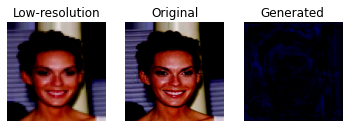

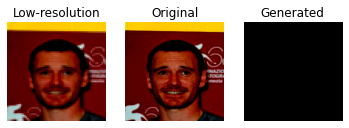

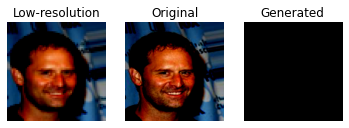

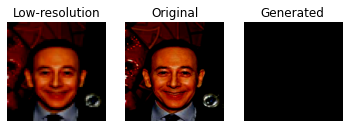

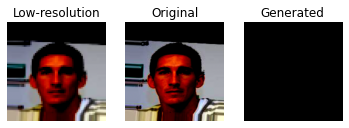

In [61]:
if __name__ == '__main__':
    data_dir = "/content/img_align_celeba/*.*"
    epochs = 30000
    batch_size = 1
    mode = 'train'

    # Shape of low-resolution and high-resolution images
    low_resolution_shape = (64, 64, 3)
    high_resolution_shape = (256, 256, 3)

    # Common optimizer for all networks
    common_optimizer = Adam(0.0002, 0.5)

    if mode == 'train':
        # Build and compile VGG19 network to extract features
        vgg = build_vgg()
        vgg.trainable = False
        vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build and compile the discriminator network
        discriminator = build_discriminator()
        discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

        # Build the generator network
        generator = build_generator()

        """
        Build and compile the adversarial model
        """

        # Input layers for high-resolution and low-resolution images
        input_high_resolution = Input(shape=high_resolution_shape)
        input_low_resolution = Input(shape=low_resolution_shape)

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator(input_low_resolution)

        # Extract feature maps of the generated images
        features = vgg(generated_high_resolution_images)

        # Make the discriminator network as non-trainable
        discriminator.trainable = False

        # Get the probability of generated high-resolution images
        probs = discriminator(generated_high_resolution_images)

        # Create and compile an adversarial model
        adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
        adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

        # Add Tensorboard
        tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
        tensorboard.set_model(generator)
        tensorboard.set_model(discriminator)

        for epoch in range(epochs):
            print("Epoch:{}".format(epoch))

            """
            Train the discriminator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Generate high-resolution images from low-resolution images
            generated_high_resolution_images = generator.predict(low_resolution_images)

            # Generate batch of real and fake labels
            real_labels = np.ones((batch_size, 16, 16, 1))
            fake_labels = np.zeros((batch_size, 16, 16, 1))

            # Train the discriminator network on real and fake images
            d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

            # Calculate total discriminator loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print("d_loss:", d_loss)

            """
            Train the generator network
            """

            # Sample a batch of images
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            # Extract feature maps for real high-resolution images
            image_features = vgg.predict(high_resolution_images)

            # Train the generator network
            g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                             [real_labels, image_features])

            print("g_loss:", g_loss)

            # Write the losses to Tensorboard
            # write_log(tensorboard, 'g_loss', g_loss[0], epoch)
            # write_log(tensorboard, 'd_loss', d_loss[0], epoch)

            # Sample and save images after every 100 epochs
            if epoch % 100 == 0:
                high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                              low_resolution_shape=low_resolution_shape,
                                                                              high_resolution_shape=high_resolution_shape)
                # Normalize images
                high_resolution_images = high_resolution_images / 127.5 - 1.
                low_resolution_images = low_resolution_images / 127.5 - 1.

                generated_images = generator.predict_on_batch(low_resolution_images)

                for index, img in enumerate(generated_images):
                    save_images(low_resolution_images[index], high_resolution_images[index], img,
                                path="/content/results/img_{}_{}".format(epoch, index))

        # Save models
        generator.save_weights("generator.h5")
        discriminator.save_weights("discriminator.h5")

    if mode == 'predict':
        # Build and compile the discriminator network
        discriminator = build_discriminator()

        # Build the generator network
        generator = build_generator()

        # Load models
        generator.load_weights("generator.h5")
        discriminator.load_weights("discriminator.h5")

        # Get 10 random images
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)
        # Normalize images
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.

        # Generate high-resolution images from low-resolution images
        generated_images = generator.predict_on_batch(low_resolution_images)

        # Save images
        for index, img in enumerate(generated_images):
            save_images(low_resolution_images[index], high_resolution_images[index], img, 
                        path="/content/results/gen_{}".format(index))